In [44]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [45]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [46]:
train_df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [47]:
test_df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [48]:
cols = ["MSSubClass", "LotArea", "PoolArea", "MiscVal", "MoSold", "YrSold"]
X_train = train_df[cols].values
X_test = test_df[cols].values
y_train = train_df.SalePrice.values.reshape(-1, 1)

In [49]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [50]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [51]:
device

'cuda'

In [52]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train,  dtype=torch.float32).to(device)

In [53]:
print(X_train.shape, y_train.shape)
print(X_test.shape)

torch.Size([1460, 6]) torch.Size([1460, 1])
torch.Size([1459, 6])


In [68]:
class NeuralNetModel(nn.Module):

    def __init__(self, input_num=6, hidden1=5, hidden2=5, output_num=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_num, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_num)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [69]:
model = NeuralNetModel().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [70]:
epochs = 500
loss_track = []
for i in range(epochs):

    # forward pass
    y_pred = model.forward(X_train)
    loss = loss_function(y_pred, y_train)

    # loss tracking
    loss_track.append(loss)

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # printing every 1000 epoch
    if (i+1) % 1000 == 0:
        print(f"epoch: {i}, loss={loss.item()}")

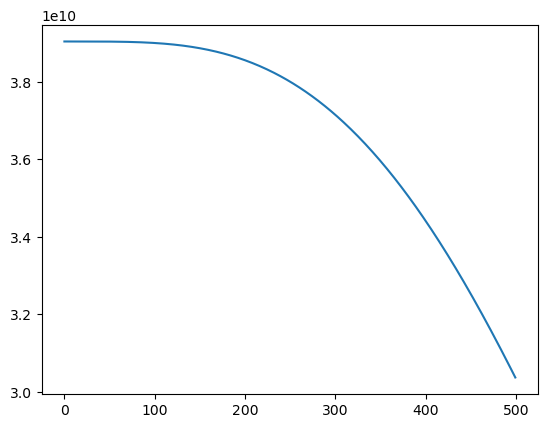

In [71]:
plt.plot([t.cpu().detach().numpy().item() for t in loss_track])

In [72]:
predicated_ans = model(X_test)

In [73]:
predicated_ans = predicated_ans.cpu().detach().numpy().reshape(-1)

In [74]:
ans_df = pd.DataFrame({"Id": test_df.Id, "SalePrice": predicated_ans})
ans_df.to_csv("outputs/ans5.csv", index=False)